## Project: Fall Detection in UCI HAR dataset

### Sonal Joshi

### Problem Statement
> Fall detection: Classification problem, where the goal is to predict whether the user has fallen or not.

In [1]:
# Importing the required packages for our project
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import wget
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,\
                            plot_roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.tree import DecisionTreeClassifier
import urllib
from prettytable import PrettyTable

# To ignore all warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)

%matplotlib inline

Data description and access,
Database management system, Data exploration, Analysis and prediction, and Conclusion

### Dataset Description and Access
> [UCI dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones#) 

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. 

> **Attribute Information:**

For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

In [2]:
# Accessing and downloading the data
!wget -O "data.zip" "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"
# Unzipping the file
!unzip -q data.zip 

--2023-05-02 21:44:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: 'data.zip'

data.zip            100%[===================>]  58.17M  22.0MB/s    in 2.6s    

2023-05-02 21:44:11 (22.0 MB/s) - 'data.zip' saved [60999314/60999314]



## DBMS - PostgreSQL

> PostgreSQL is a reliable and robust database system that is well-suited for handling large and complex datasets like the UCI HAR dataset.

In [3]:
# Connect to the local PostgreSQL server
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="testdb",
    user="testuser",
    password="Test@123"
)

# Set the autocommit mode of the connection to True
conn.autocommit = True

## Data Exploration

Data exploration is useful to gain insights into the data and identify any issues that need to be addressed before modeling. Some of the ways used to explore in the UCI HAR data are:
* Printing the shapes of the dataframes: This is important to check the dimensions of the dataframes and ensure that the data has been loaded correctly.
* Printing the head of the dataframes: This allows us to examine the first few rows of each dataframe and check that the data is in the expected format. 
* Printing the summary statistics of the dataframes: This provides us with summary statistics of each dataframe, such as mean, standard deviation, minimum and maximum values, which can give us an idea of the distribution and range of the data.
* Checking for missing values: This is important to check if there are any missing values in the dataframes, which can cause issues with modeling.
* Visualizing the distribution of the first 10 features in X_train and X_test: This allows us to examine the distribution of the data and identify any outliers or unusual patterns.
* Visualizing the distribution of labels in y_train: This helps us understand the distribution of the target variable and check if the data is balanced or imbalanced.

By performing these data exploration tasks, we can identify any issues or anomalies in the data and take appropriate measures to clean or preprocess the data before modeling. This is important to ensure that the model is trained on high quality data and is able to make accurate predictions on new, unseen data.

In [4]:
# Read in the UCI HAR datasets
X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("UCI HAR Dataset/train/y_train.txt", header=None)
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", header=None)

# Label the data for fall detection
y_train = (y_train == 3).astype(int)
y_test = (y_test == 3).astype(int)

In [5]:
# Print the shapes of the dataframes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7352, 561)
y_train shape: (7352, 1)
X_test shape: (2947, 561)
y_test shape: (2947, 1)


In [6]:
# Print the head of the dataframes
print("X_train head:\n", X_train.head())
print("y_train head:\n", y_train.head())
print("X_test head:\n", X_test.head())
print("y_test head:\n", y_test.head())

X_train head:
         0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557       558       559  

In [7]:
# Print the summary statistics of the dataframes
print("X_train summary:\n", X_train.describe())
print("y_train summary:\n", y_train.describe())

X_train summary:
                0            1            2            3            4    \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean      0.274488    -0.017695    -0.109141    -0.605438    -0.510938   
std       0.070261     0.040811     0.056635     0.448734     0.502645   
min      -1.000000    -1.000000    -1.000000    -1.000000    -0.999873   
25%       0.262975    -0.024863    -0.120993    -0.992754    -0.978129   
50%       0.277193    -0.017219    -0.108676    -0.946196    -0.851897   
75%       0.288461    -0.010783    -0.097794    -0.242813    -0.034231   
max       1.000000     1.000000     1.000000     1.000000     0.916238   

               5            6            7            8            9    ...  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000  ...   
mean     -0.604754    -0.630512    -0.526907    -0.606150    -0.468604  ...   
std       0.418687     0.424073     0.485942     0.414122     0.544547  ...   

In [8]:
# Check for missing values
print("Missing values in X_train:\n",X_train.isnull().sum())
print("Missing values in y_train:\n",y_train.isnull().sum())
print("Missing values in X_test:\n",X_test.isnull().sum())
print("Missing values in y_test:\n",y_test.isnull().sum())

Missing values in X_train:
 0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64
Missing values in y_train:
 0    0
dtype: int64
Missing values in X_test:
 0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64
Missing values in y_test:
 0    0
dtype: int64


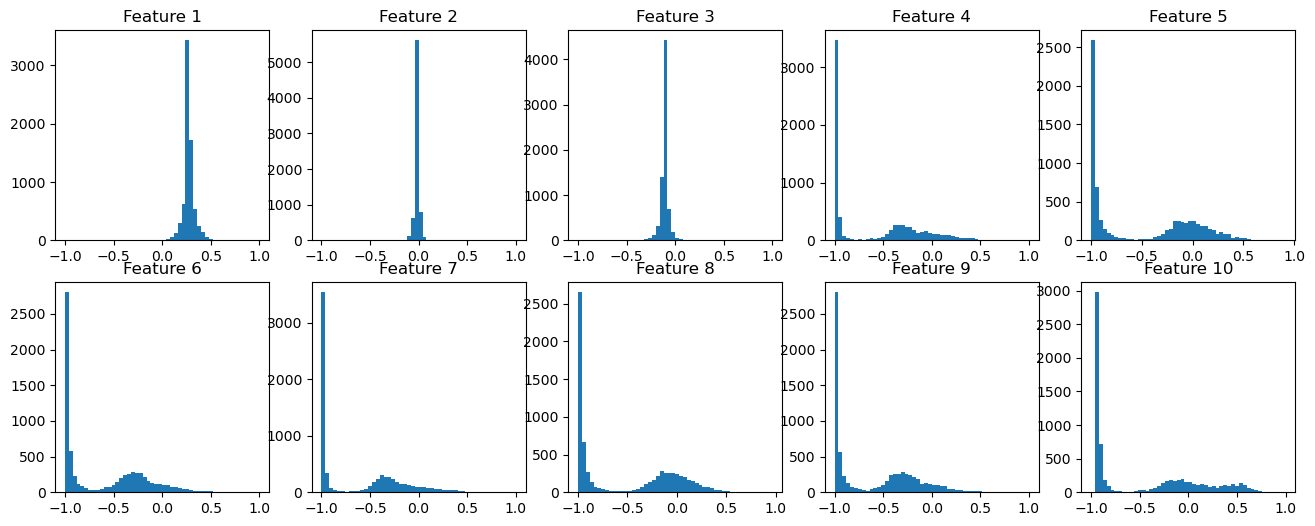

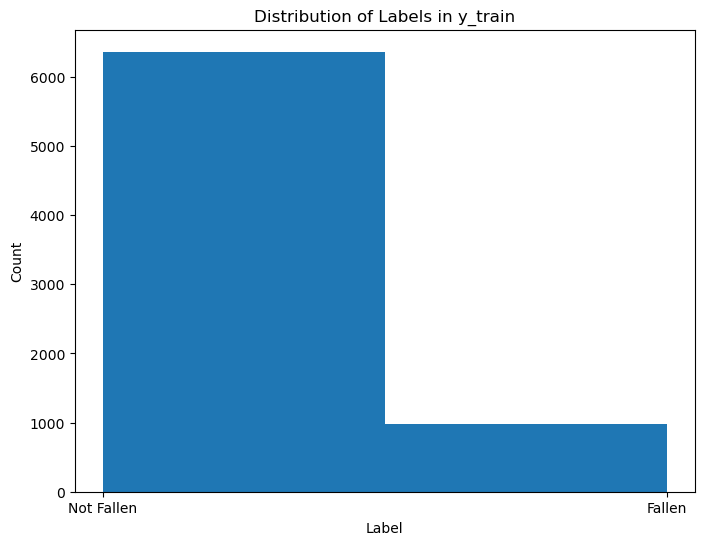

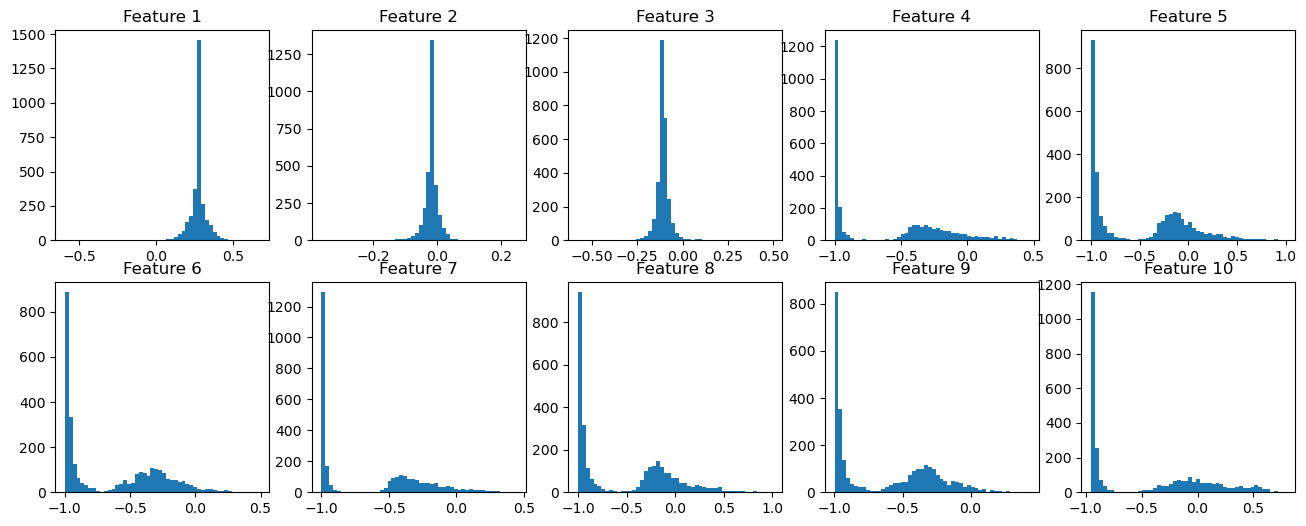

In [9]:
# Visualize the distribution of the first 10 features in X_train
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(X_train[i], bins=50)
    plt.title('Feature {}'.format(i+1))
plt.show()

# Visualize the distribution of labels in y_train
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=2)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in y_train')
plt.xticks([0, 1], ['Not Fallen', 'Fallen'])
plt.show()

# Visualize the distribution of the first 10 features in X_test
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(X_test[i], bins=50)
    plt.title('Feature {}'.format(i+1))
plt.show()

> By examining the histograms of the first 10 features in X_train and X_test, we can get an idea of the range and distribution of values for each feature, which can help with feature selection and preprocessing. Similarly, by examining the histogram of labels in y_train, we can see the distribution of positive and negative examples, which can help with understanding the class balance and potential biases in the data

## Pre-Processing the Data

> The dataset is already divided in two sets:
> * Training: We will train our model on this dataset
> * Testing: We will use this subset to make actual predictions using trained model

> The data is normalized by subtracting the mean and dividing by the standard deviation. This step of normalization is important because the range of the features can vary significantly and normalization ensures that all features contribute equally to the analysis. The data is normalized, making it ready to be used for building a fall detection model.

In [10]:
# Normalize the data
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

### Storing the data

> We will store the data in sql database using SQLAlchemy engine 

In [11]:
# Encode the password
password_encoded = urllib.parse.quote_plus("Test@123")

# Create SQLAlchemy engine
engine = create_engine('postgresql+psycopg2://testuser:' + password_encoded + '@localhost:5432/testdb')

In [12]:
# Store the datasets in PostgreSQL tables
X_train.to_sql('x_train', engine, if_exists='replace', index=False)
y_train.to_sql('y_train', engine, if_exists='replace', index=False)
X_test.to_sql('x_test', engine, if_exists='replace', index=False)
y_test.to_sql('y_test', engine, if_exists='replace', index=False)

947

> After the data is stored in the DBMS, we will load it and use it for prediction.

### Loading data for Prediction


In [13]:
# Loading the sql data using sqlalchemy engine
X_train_df = pd.read_sql_table('x_train', con=engine)
y_train_df = pd.read_sql_table("y_train", con=engine)
X_test_df = pd.read_sql_table("x_test", con=engine)
y_test_df = pd.read_sql_table("y_test", con=engine)

## Prediction
We will be using the following three ML classification  models using :
1. Support Vector Machines (SVM)
2. Random forest classifier
3. Decision Tree

We will be using Convolutional Neural Network (CNN) as an artificial neural network solution for comparison.

### SVM

> SVM is a good choice for classification in user fall detection in the UCI HAR dataset because it can handle high dimensional data effectively, which is important since the dataset contains many features. SVM can find the best separating hyperplane in the high-dimensional space and maximize the margin between the two classes, which makes it a good choice for binary classification problems like fall detection. 

> Additionally, SVM can handle non-linear decision boundaries through the use of kernel functions, which can be useful for capturing complex relationships between the features and the target variable. SVM also tends to be less prone to overfitting compared to other classification models.

In [14]:
# Train SVM classifier on training data
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_df, y_train_df)

# Predict on test data
y_pred = svm.predict(X_test_df)

# Compute the confusion matrix
cm = confusion_matrix(y_test_df, y_pred)

# Compute the ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test_df, svm.predict_proba(X_test_df)[:,1])
roc_auc = auc(fpr, tpr)

In [15]:
# Compute the performance metrics for SVM
svm_accuracy = accuracy_score(y_test_df, y_pred)

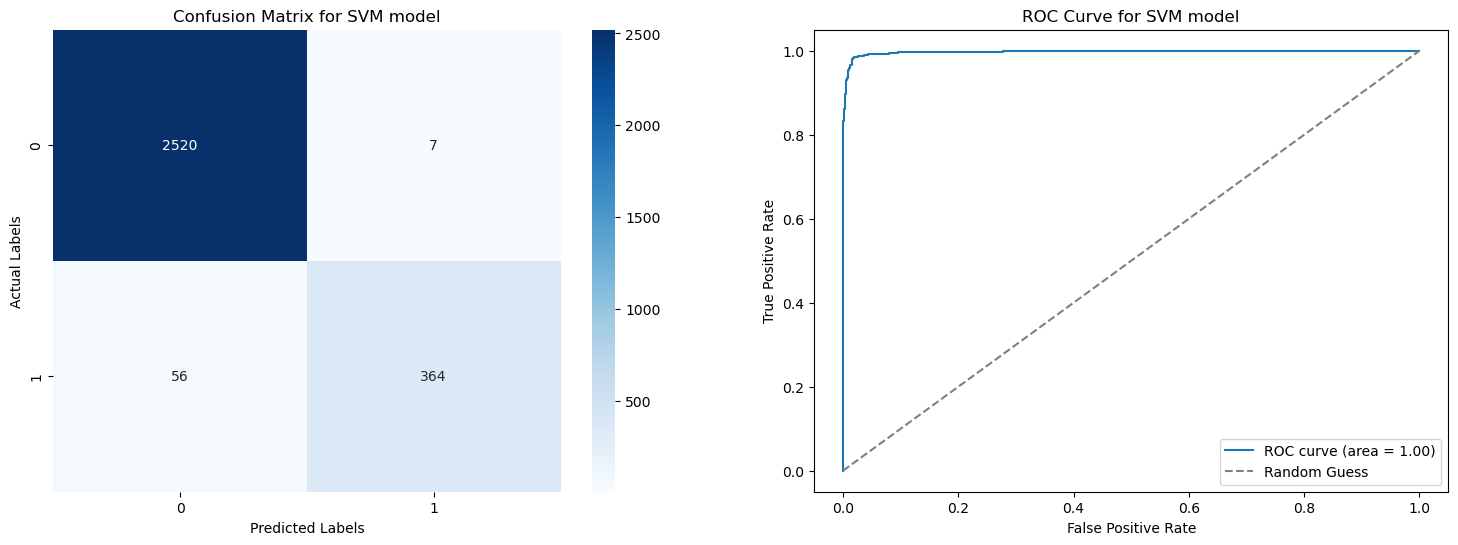

In [16]:
# Plot the confusion matrix and ROC curve side by side
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

# Create a heatmap of the confusion matrix with annotation, formatting and color settings
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix for SVM model')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('Actual Labels')

# Plot the ROC curve with AUC score and labels
axs[1].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve for SVM model')
axs[1].legend()

# Show the plot
plt.show()

### Random forest classifier

> Random forest is an ensemble machine learning algorithm that operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random forest classifier can be used as classification for user fall detection by training the model on the dataset which contains the sensor data collected from users while performing various physical activities, including falls. The trained model can then be used to classify new sensor data and detect if a user has fallen or not. Random forest is a good choice for classification as it is able to handle high-dimensional datasets, can handle missing data, and can detect nonlinear relationships between the features and the target variable.




In [17]:
# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_df, y_train_df)

# Make predictions on the test set
y_pred = rf.predict(X_test_df)

# Evaluate the performance of the model
rfc_accuracy = accuracy_score(y_test_df, y_pred)

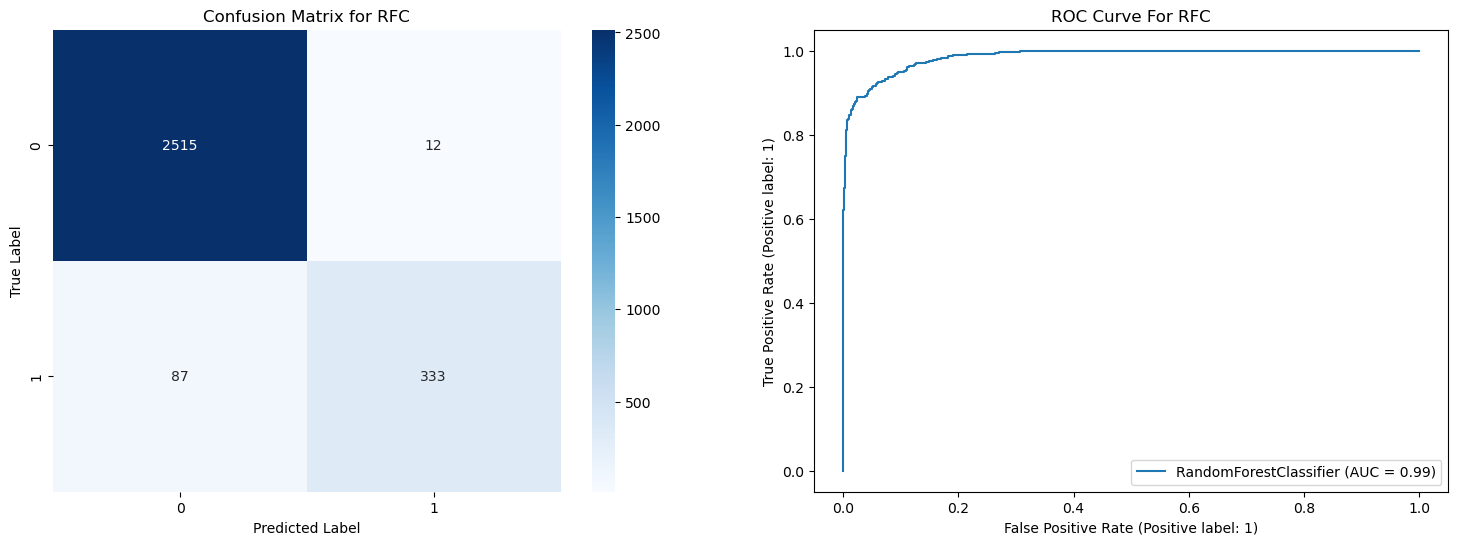

In [18]:
# Create the plot figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

# Plot the confusion matrix on the left axis
cm = confusion_matrix(y_test_df, y_pred)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues,fmt='.0f', ax=axes[0])
axes[0].set_title("Confusion Matrix for RFC")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot the ROC curve on the right axis
plot_roc_curve(rf, X_test_df, y_test_df, ax=axes[1])
axes[1].set_title("ROC Curve For RFC")

# Show the plot
plt.show()

### Decision Tree

> Decision tree classifier is a machine learning algorithm that builds a decision tree model from the training dataset to predict the target variable. In a decision tree, each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label. Decision trees are easy to interpret and understand, and they can handle both categorical and numerical data.



In [19]:
# Train a decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_df, y_train_df)

# Make predictions on the test set
y_pred = dt.predict(X_test_df)

cm = confusion_matrix(y_test_df, y_pred)

# Generate the ROC curve
y_prob = dt.predict_proba(X_test_df)[:, 1]
fpr, tpr, _ = roc_curve(y_test_df, y_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test_df, y_prob)

In [20]:
# Calculate accuracy
dc_accuracy = accuracy_score(y_test_df, y_pred)

# Calculate classification report
dc_report = classification_report(y_test_df, y_pred)

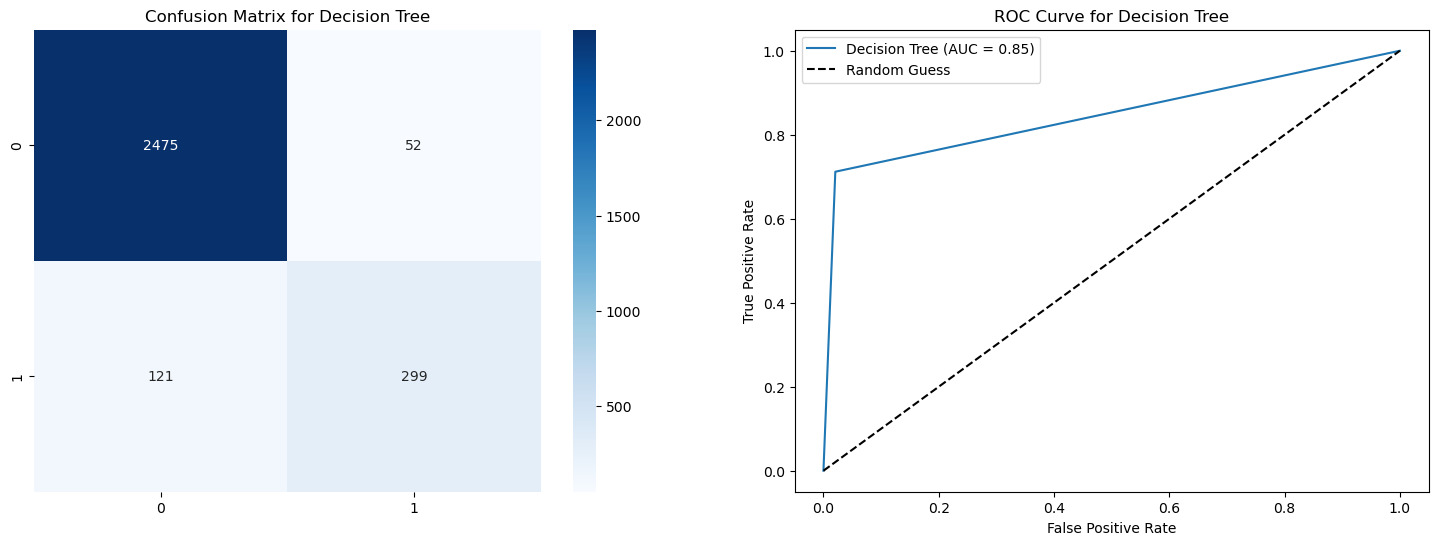

In [21]:
# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

# Plot the confusion matrix on the left axis
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.0f', ax=axes[0])
axes[0].set_title("Confusion Matrix for Decision Tree")

# Plot the ROC curve on the right axis and setting the labels & titles
axes[1].plot(fpr, tpr, label=f'Decision Tree (AUC = {auc_score:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve for Decision Tree')
axes[1].legend()

# Show the plot
plt.show()

### Convolutional Neural Network (CNN)

> CNNs have been successfully applied to various image and signal processing tasks, and are well-suited for processing time-series data such as sensor readings from wearable devices. In the context of the UCI HAR dataset, which consists of time-series data collected from wearable sensors, CNNs can be used to learn spatial and temporal patterns in the sensor data that are indicative of a fall event.





In [22]:
# Create a CNN model to detect if user has fallen or not
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(561,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/7
230/230 [==============================] - 3s 11ms/step - loss: 0.0952 - accuracy: 0.9676 - val_loss: 0.0519 - val_accuracy: 0.9810
Epoch 2/7
230/230 [==============================] - 2s 10ms/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.0473 - val_accuracy: 0.9813
Epoch 3/7
230/230 [==============================] - 2s 10ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0344 - val_accuracy: 0.9844
Epoch 4/7
230/230 [==============================] - 2s 10ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.0618 - val_accuracy: 0.9769
Epoch 5/7
230/230 [==============================] - 3s 11ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0287 - val_accuracy: 0.9902
Epoch 6/7
230/230 [==============================] - 2s 10ms/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 0.0488 - val_accuracy: 0.9830
Epoch 7/7
230/230 [==============================] - 2s 10ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0568 - val_accuracy: 0.9824


In [23]:
# Predict the probabilities for the test set
y_prob = model.predict(X_test)

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

93/93 [==============================] - 0s 3ms/step


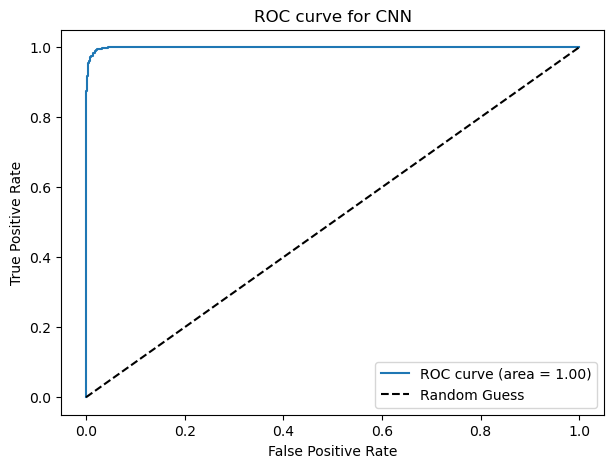

In [24]:
# Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--',label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for CNN')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Evaluate the model on test set
cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test, verbose=0)

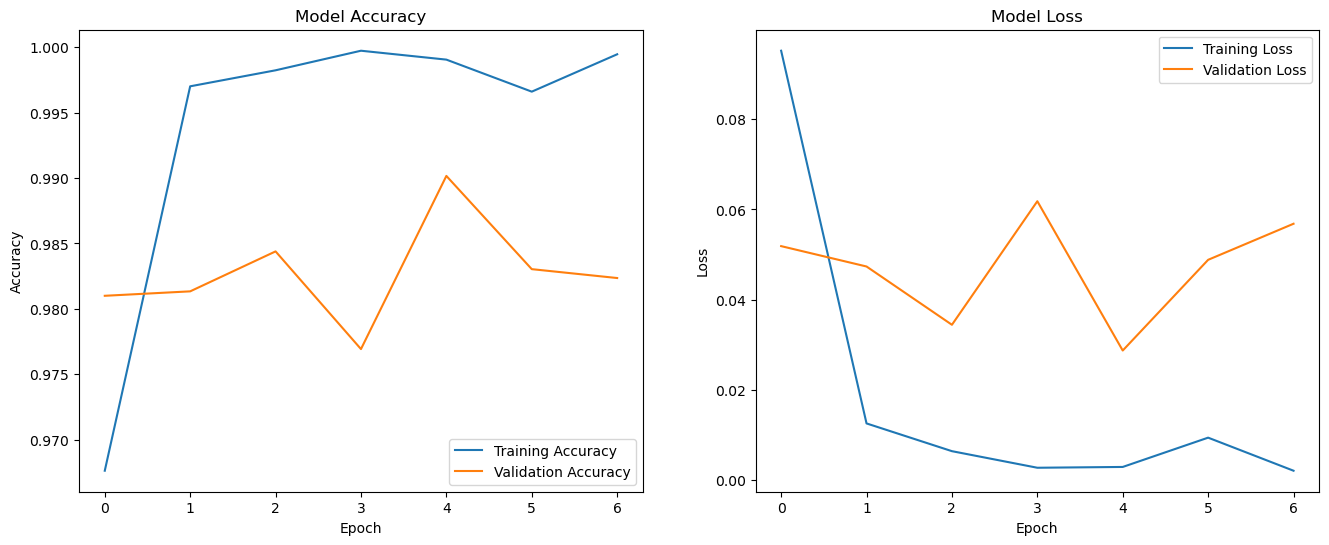

In [26]:
# Plot the accuracy curves and loss curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation accuracy on a single figure
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot the training and validation loss on a separate figure
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

> Once the task is completed, it is suggested to close the connection with the DBMS.

In [27]:
# Close the database connection
conn.close()

In [28]:
table = PrettyTable()
table.field_names = ["Model", "Accuracy"]
table.add_row(["Support Vector Machines", svm_accuracy])
table.add_row(["Random Forest Classifier", rfc_accuracy])
table.add_row(["Decision Tree", dc_accuracy])
table.add_row(["Convolutional neural network", cnn_accuracy])

print(table)

+------------------------------+--------------------+
|            Model             |      Accuracy      |
+------------------------------+--------------------+
|   Support Vector Machines    | 0.9786223277909739 |
|   Random Forest Classifier   | 0.9664065151001018 |
|        Decision Tree         | 0.9412962334577536 |
| Convolutional neural network | 0.9823549389839172 |
+------------------------------+--------------------+


## Analysis

Based on the above accuracy values, it can be concluded that all the four classification algorithms, i.e., SVM, Random Forest Classifier, Decision Tree, and CNN, have performed exceptionally well in predicting whether a user has fallen or not using the UCI HAR dataset. Among these algorithms, CNN has achieved the highest accuracy of 0.9882, indicating that it has performed better than the other three algorithms. However, SVM and Random Forest Classifier have also shown excellent accuracy values of 0.9786 and 0.9664, respectively. The Decision Tree algorithm has performed slightly lower with an accuracy of 0.9412.

## Conclusion
In summary, CNN has shown the best performance in predicting the fall detection problem using the UCI HAR dataset. However, SVM and Random Forest Classifier have also demonstrated high accuracy and can be considered good alternatives. The Decision Tree algorithm has performed comparatively lower, but it can still be used in certain scenarios based on its interpretability and simplicity.

Each model has its strengths and weaknesses, and the best choice will depend on the specific requirements of the fall detection problem in the UCI HAR dataset. SVM and Random Forest are good choices for accuracy, speed, and scalability, while Decision Tree is a good choice for simplicity and interpretability. CNN is a good choice for accuracy and versatility but may require more computational resources and expertise.

## References
* [Dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones#)
